# Introduction to Machine Learning

- Teilnehmende werden fast kein Python kennen
- Google Colab
- Einführung in Python kurz halten -> evtl. zumindest kurz erklären, was eine Funktion ist
- Regression in sklearn
- Übergang zu PyTorch -> Motivieren, warum PyTorch für komplexere Modelle besser geignet ist
- Englisch!!!

In [1]:
from joblib import dump, load
from sklearn.metrics import accuracy_score

from tqdm import tqdm
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
sns.set_theme(context="notebook")

# We first work on the 2D dataset called "PathMNIST"

The following cell give us some first information about this dataset. We are dealing with an image dataset containing RGB impage patches from hematoxylin & eosin stained histological images, obtained in different clinical centers.

Since we are dealing with RGB image patches, we have three different channels.

In total, there are nine different classes. Hence, we have a multi-class dataset, and each image is assigned to exactly one class.

The training and validation set (NCT-CRC-HE-100K) contain 100,000 patches, and the test set contains 7,180 image patches (CRC-VAL-HE-7K) from a different clinical center.

In [3]:
data_flag = 'pathmnist'
# data_flag = 'breastmnist'

info = INFO[data_flag]
task = info['task']
labels = info['label']

n_channels = info['n_channels']
n_classes = len(info['label'])

info

{'python_class': 'PathMNIST',
 'description': 'The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and split NCT-CRC-HE-100K into training and validation set with a ratio of 9:1. The CRC-VAL-HE-7K is treated as the test set.',
 'url': 'https://zenodo.org/record/6496656/files/pathmnist.npz?download=1',
 'MD5': 'a8b06965200029087d5bd730944a56c1',
 'task': 'multi-class',
 'label': {'0': 'adipose',
  '1': 'background',
  '2': 'debris',
  '3': 'lymphocytes',
  '4': 'mucus',
  '5': 'smooth muscle',
  '6': 'normal colon mucosa',
  '7': 'cancer-associated stroma',
  '8': '

We prepare to download the dataset (if it is not already downloaded) and instantiate

In [4]:
download = True

## First, we read the raw MedMNIST data without any preprocessing

Since we want to dive deeper into the dataset, we do not apply any kind of preprocessing. We only make sure that the dataset class returns the data as `torch.Tensor`, such that we can easily analyze it further.

Note that we create two different datasets, one for training and one for test. This is something that we always need to keep in mind. Always split training and test data and make sure that no test data is used for training or parameter optimization.

In [5]:
BATCH_SIZE = 128
N_PIXELS = 28*28

validation_split = .2

# preprocessing
data_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
DataClass = getattr(medmnist, info['python_class'])
train_dataset = DataClass(split='train', transform=data_transform,
                          download=download)
test_dataset = DataClass(split='test', transform=data_transform,
                         download=download)

# Creating data indices for training and validation splits:
train_dataset_size = len(train_dataset)
indices = list(range(train_dataset_size))
split = int(np.floor(validation_split * train_dataset_size))

train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = data.sampler.SubsetRandomSampler(train_indices)
valid_sampler = data.sampler.SubsetRandomSampler(val_indices)

# encapsulate data into dataloader form
cv_train_loader = data.DataLoader(
    dataset=train_dataset, batch_size=BATCH_SIZE,
    sampler=train_sampler)
cv_validation_loader = data.DataLoader(
    dataset=train_dataset, batch_size=BATCH_SIZE,
    sampler=valid_sampler)
train_loader = data.DataLoader(
    dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(
    dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

Using downloaded and verified file: C:\Users\Steiner\.medmnist\pathmnist.npz
Using downloaded and verified file: C:\Users\Steiner\.medmnist\pathmnist.npz


In [6]:
training_input = []
training_target = []
for data in tqdm(train_loader):
    training_input.append(data[0].numpy().reshape(-1, N_PIXELS))
    training_target.append(data[1].numpy().flatten())

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:11<00:00, 63.53it/s]


In [7]:
training_df = pd.DataFrame(np.vstack(training_input), columns=[f"Pixel {k+1}" for k in range(N_PIXELS)])
training_df["Target"] = [labels[str(d)] for d in np.hstack(training_target)]
training_df["Numeric target"] = np.hstack(training_target)

In [8]:
training_df

,Pixel 1,Pixel 2,Pixel 3,Pixel 4,Pixel 5,Pixel 6,Pixel 7,Pixel 8,Pixel 9,Pixel 10,...,Pixel 777,Pixel 778,Pixel 779,Pixel 780,Pixel 781,Pixel 782,Pixel 783,Pixel 784,Target,Numeric target
0,0.341177,0.498039,0.458824,0.505882,0.349020,-0.247059,-0.098039,0.027451,0.160784,0.247059,...,0.223529,0.278431,0.066667,0.082353,0.184314,0.349020,0.545098,0.411765,mucus,4
1,0.082353,0.411765,0.356863,0.537255,0.403922,0.278431,0.082353,0.427451,-0.058824,-0.113725,...,0.388235,0.403922,0.513726,0.341177,0.294118,0.356863,0.325490,0.396078,lymphocytes,3
2,0.019608,0.129412,0.129412,-0.160784,-0.160784,-0.066667,0.231373,0.717647,0.850980,0.882353,...,0.050980,-0.082353,0.011765,-0.050980,-0.003922,0.184314,0.733333,0.882353,colorectal adenocarcinoma epithelium,8
3,0.741176,0.741176,0.686275,0.513726,0.576471,0.725490,0.741176,0.741176,0.741176,0.741176,...,0.584314,0.592157,0.592157,0.458824,0.545098,0.560784,0.498039,0.498039,adipose,0
4,0.231373,0.176471,0.317647,0.286275,0.270588,0.231373,0.121569,0.066667,0.043137,0.082353,...,0.270588,0.035294,0.027451,0.207843,0.419608,0.419608,0.066667,0.113726,debris,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89991,0.803922,0.803922,0.788235,0.780392,0.780392,0.788235,0.788235,0.796078,0.796078,0.811765,...,0.772549,0.764706,0.796078,0.819608,0.796078,0.780392,0.780392,0.811765,background,1
89992,0.741176,0.741176,0.741176,0.709804,0.631373,0.576471,0.694118,0.733333,0.725490,0.725490,...,0.333333,0.278431,0.011765,-0.003922,-0.207843,-0.552941,-0.435294,0.043137,adipose,0
89993,0.207843,0.247059,0.223529,0.035294,-0.082353,0.027451,-0.019608,0.035294,0.184314,0.043137,...,-0.090196,-0.184314,-0.223529,0.035294,-0.043137,0.011765,0.027451,0.176471,colorectal adenocarcinoma epithelium,8
89994,0.890196,0.890196,0.584314,0.019608,0.537255,0.843137,0.474510,0.160784,0.701961,0.850980,...,-0.050980,-0.035294,0.035294,0.160784,0.152941,0.137255,0.215686,0.270588,colorectal adenocarcinoma epithelium,8


## Visualization

Visualization is always a crucial part when getting started with a new dataset. Even when only looking on samples, we get a better idea of what is contained in the dataset.

Here, we observe severa interesting things:

- The pixel values (mean of the different RGB values) seem to be normalized, as we do not deal with integer values.
- The value ranges are different. In most of the images, the values seem to lie between 0.3 and 0.8, but not always.
- The histograms indicate that the pixel values overall are distributed reasonable.
- All pixels seem to carry information, as the distribution does not indicate that some pixel values have a small standard deviation.

All in all, this suggests that the pre-processing is simple in case of this dataset. We will simply shift each pixel value by 0.5 and 

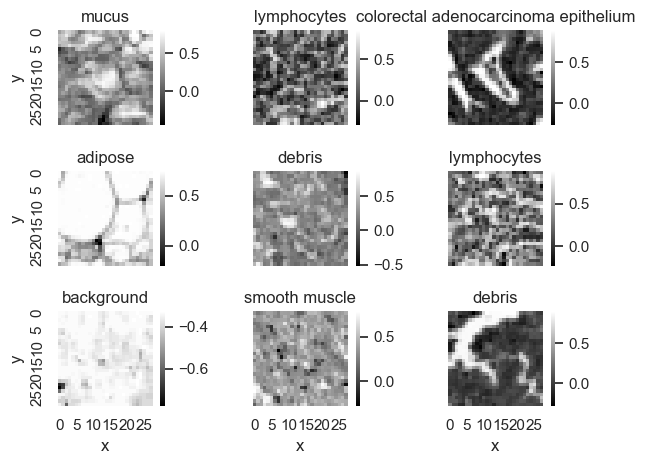

In [9]:
fig, axs = plt.subplots(3, 3, sharex="all", sharey="all")

for k in range(9):
    sns.heatmap(data=training_df.loc[k, [f"Pixel {k+1}" for k in range(N_PIXELS)]].values.astype(float).reshape(28, 28).T,
                ax=axs.flatten()[k], square=True, cmap="gray")
    axs.flatten()[k].set_title(training_df.loc[k, "Target"])

[ax.set_xlabel("x") for ax in axs[-1, :]]
[ax.set_ylabel("y") for ax in axs[:, 0]]
plt.tight_layout()

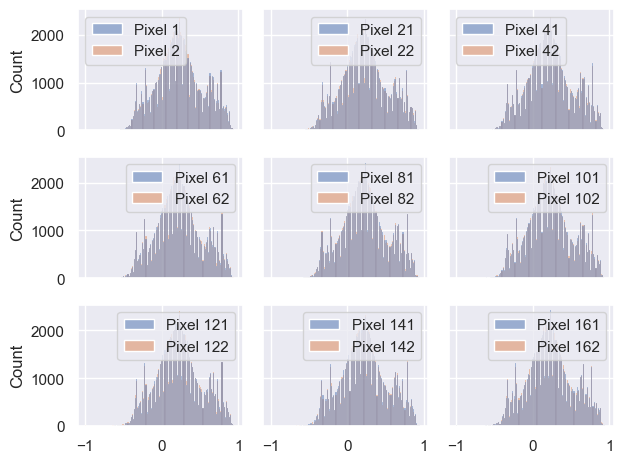

In [10]:
fig, axs = plt.subplots(3, 3, sharex="all", sharey="all")

sns.histplot(data=training_df.loc[:, [f"Pixel {k+1}" for k in range(0, 2)]], ax=axs.flatten()[0])
sns.histplot(data=training_df.loc[:, [f"Pixel {k+1}" for k in range(20, 22)]], ax=axs.flatten()[1])
sns.histplot(data=training_df.loc[:, [f"Pixel {k+1}" for k in range(40, 42)]], ax=axs.flatten()[2])
sns.histplot(data=training_df.loc[:, [f"Pixel {k+1}" for k in range(60, 62)]], ax=axs.flatten()[3])
sns.histplot(data=training_df.loc[:, [f"Pixel {k+1}" for k in range(80, 82)]], ax=axs.flatten()[4])
sns.histplot(data=training_df.loc[:, [f"Pixel {k+1}" for k in range(100, 102)]], ax=axs.flatten()[5])
sns.histplot(data=training_df.loc[:, [f"Pixel {k+1}" for k in range(120, 122)]], ax=axs.flatten()[6])
sns.histplot(data=training_df.loc[:, [f"Pixel {k+1}" for k in range(140, 142)]], ax=axs.flatten()[7])
sns.histplot(data=training_df.loc[:, [f"Pixel {k+1}" for k in range(160, 162)]], ax=axs.flatten()[8])

plt.tight_layout()

In [11]:
from sklearn.decomposition import PCA


pca = PCA().fit(training_df.loc[:, [f"Pixel {k+1}" for k in range(N_PIXELS)]])

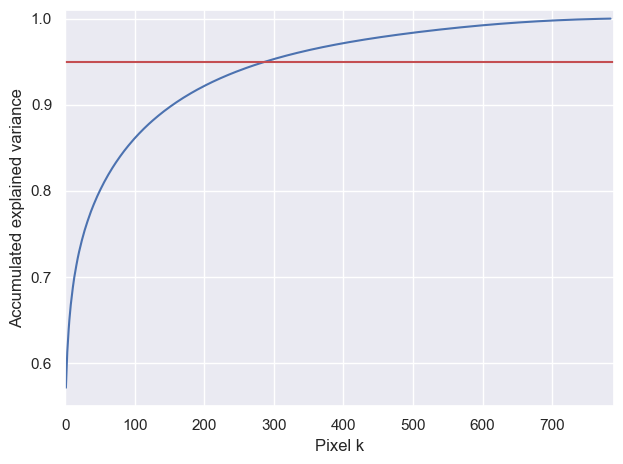

In [12]:
fig, axs = plt.subplots()

sns.lineplot(x=np.arange(1, 785), y=np.cumsum(pca.explained_variance_ratio_), ax=axs)
axs.axhline(y=0.95, c="r")
axs.set_xlabel("Pixel k")
axs.set_ylabel("Accumulated explained variance")
axs.set_xlim((0, N_PIXELS+5))
axs.set_ylim((0.55, 1.01))
plt.tight_layout()

In [13]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedShuffleSplit
from sklearn.linear_model import SGDClassifier
from sklearn.utils.fixes import loguniform


try:
    clf = load("sklearn_linear_model.joblib")
except FileNotFoundError:
    clf = RandomizedSearchCV(estimator=SGDClassifier(loss="log_loss"), n_iter=50,
                             n_jobs=6, cv=3, verbose=10,
                             param_distributions={"alpha": loguniform(a=1e-5, b=1e1)}).fit(
        training_df.loc[:, [f"Pixel {k+1}" for k in range(N_PIXELS)]], y=training_df.loc[:, "Numeric target"])
    dump(clf, "sklearn_linear_model.joblib")

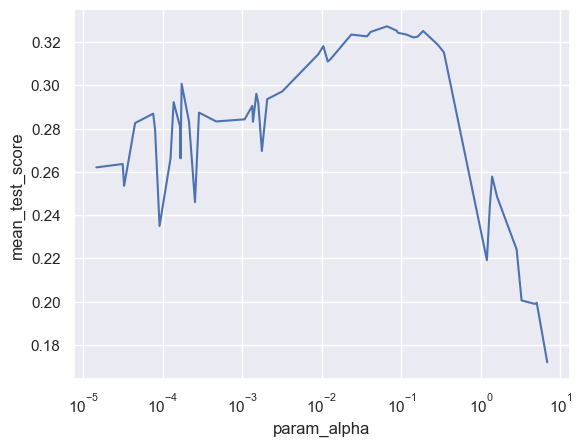

In [14]:
fig, axs = plt.subplots()

sns.lineplot(data=pd.DataFrame(clf.cv_results_), x="param_alpha", y="mean_test_score", ax=axs)
plt.xscale("log")

In [15]:
clf.score(training_df.loc[:, [f"Pixel {k+1}" for k in range(N_PIXELS)]],
          y=training_df.loc[:, "Numeric target"])

0.3303369038623939

In [16]:
test_input = []
test_target = []
for data in tqdm(test_loader):
    test_input.append(data[0].numpy().reshape(-1, N_PIXELS))
    test_target.append(data[1].numpy().flatten())

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 31.70it/s]


In [17]:
test_df = pd.DataFrame(np.vstack(test_input), columns=[f"Pixel {k+1}" for k in range(N_PIXELS)])
test_df["Target"] = [labels[str(d)] for d in np.hstack(test_target)]
test_df["Numeric target"] = np.hstack(test_target)

In [18]:
clf.score(test_df.loc[:, [f"Pixel {k+1}" for k in range(N_PIXELS)]], y=test_df.loc[:, "Numeric target"])

0.44220055710306405

## Then, we define a simple model for illustration, object function and optimizer that we use to classify.

In [19]:
class EarlyStopping:
    """
    Stop the training early if the validation loss 
    doesn't improve after a given patience.

    Parameters
    ----------
    patience: int, default=7
        How long to wait after last time validation loss improved.
    verbose : bool, default=False
        If True, prints a message for each validation loss improvement. 
    delta : float, default=0.
        Minimum change in the monitored quantity to qualify as an improvement.
    path : str or Path, default='checkpoint.pt'
        Path for the checkpoint to be saved to.
    trace_func : Callable, default=print
        trace print function.            
    """
    def __init__(self, patience=7, verbose=False, delta=0,
                 path='torch_linear_model.pt', trace_func=print):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.minimum_validation_loss = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, validation_loss, model, optimizer, epoch):
        score = -validation_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(validation_loss, model, optimizer, epoch)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(
                f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(validation_loss, model, optimizer, epoch)
            self.counter = 0

    def save_checkpoint(self, validation_loss, model, optimizer, epoch):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(
                f'Validation loss decreased ({self.minimum_validation_loss:.6f} '
                f'--> {validation_loss:.6f}).  Saving model ...')
        torch.save({'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'validation_loss': validation_loss,
                    }, self.path)
        self.minimum_validation_loss = validation_loss

In [20]:
# define a simple linear regression model

NUM_EPOCHS = 500


class LinearRegression(nn.Module):
    def __init__(self, n_pixels, num_classes):
        super(LinearRegression, self).__init__()
        self.linear_layer = nn.Linear(n_pixels, num_classes)

    def forward(self, x):
        x = x.reshape(x.shape[0], -1)
        x = self.linear_layer(x)
        return x


model = LinearRegression(n_pixels=784, num_classes=n_classes)    
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3, weight_decay=1e-2)

In [21]:
def train_model(model, patience, n_epochs):
    # to track the training loss as the model trains
    training_losses = []
    # to track the validation loss as the model trains
    validation_losses = []
    # to track the average training loss per epoch as the model trains
    average_training_losses = []
    # to track the average validation loss per epoch as the model trains
    average_validation_losses = [] 
    
    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    for epoch in range(1, n_epochs + 1):
        ###################
        # train the model #
        ###################
        model.train() # prep model for training
        for batch, (data, target) in enumerate(cv_train_loader, 1):
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            target = target.squeeze().long()
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record training loss
            training_losses.append(loss.item())

        ######################    
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        for data, target in cv_validation_loader:
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            target = target.squeeze().long()
            loss = criterion(output, target)
            # record validation loss
            validation_losses.append(loss.item())

        # print training/validation statistics 
        # calculate average loss over an epoch
        training_loss = np.average(training_losses)
        validation_loss = np.average(validation_losses)
        average_training_losses.append(training_loss)
        average_validation_losses.append(validation_loss)
        
        epoch_len = len(str(n_epochs))
        
        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {training_loss:.5f} ' +
                     f'valid_loss: {validation_loss:.5f}')
        
        print(print_msg)
        
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
        
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(validation_loss, model, optimizer, epoch)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
    # load the last checkpoint with the best model
    checkpoint = torch.load("torch_linear_model.pt")
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']

    return  model, optimizer, epoch, loss, average_training_losses, average_validation_losses

In [ ]:
# early stopping patience; how long to wait after last time validation loss improved.
patience = 20
model, train_loss, valid_loss = train_model(model, patience, NUM_EPOCHS)

[  1/500] train_loss: 2.12356 valid_loss: 2.11820
Validation loss decreased (inf --> 2.118203).  Saving model ...
[  2/500] train_loss: 2.11588 valid_loss: 2.11495
Validation loss decreased (2.118203 --> 2.114947).  Saving model ...
[  3/500] train_loss: 2.11095 valid_loss: 2.11159
Validation loss decreased (2.114947 --> 2.111588).  Saving model ...
[  4/500] train_loss: 2.10687 valid_loss: 2.10841
Validation loss decreased (2.111588 --> 2.108406).  Saving model ...
[  5/500] train_loss: 2.10319 valid_loss: 2.10538
Validation loss decreased (2.108406 --> 2.105376).  Saving model ...
[  6/500] train_loss: 2.09980 valid_loss: 2.10240
Validation loss decreased (2.105376 --> 2.102402).  Saving model ...
[  7/500] train_loss: 2.09660 valid_loss: 2.09951
Validation loss decreased (2.102402 --> 2.099514).  Saving model ...
[  8/500] train_loss: 2.09357 valid_loss: 2.09686
Validation loss decreased (2.099514 --> 2.096865).  Saving model ...
[  9/500] train_loss: 2.09067 valid_loss: 2.09426
Val

[ 70/500] train_loss: 2.01097 valid_loss: 2.02213
Validation loss decreased (2.022701 --> 2.022133).  Saving model ...
[ 71/500] train_loss: 2.01035 valid_loss: 2.02158
Validation loss decreased (2.022133 --> 2.021577).  Saving model ...
[ 72/500] train_loss: 2.00973 valid_loss: 2.02103
Validation loss decreased (2.021577 --> 2.021031).  Saving model ...
[ 73/500] train_loss: 2.00913 valid_loss: 2.02050
Validation loss decreased (2.021031 --> 2.020503).  Saving model ...
[ 74/500] train_loss: 2.00854 valid_loss: 2.01998
Validation loss decreased (2.020503 --> 2.019979).  Saving model ...
[ 75/500] train_loss: 2.00796 valid_loss: 2.01946
Validation loss decreased (2.019979 --> 2.019459).  Saving model ...
[ 76/500] train_loss: 2.00739 valid_loss: 2.01895
Validation loss decreased (2.019459 --> 2.018955).  Saving model ...
[ 77/500] train_loss: 2.00682 valid_loss: 2.01845
Validation loss decreased (2.018955 --> 2.018452).  Saving model ...
[ 78/500] train_loss: 2.00627 valid_loss: 2.0179

[139/500] train_loss: 1.98339 valid_loss: 1.99795
Validation loss decreased (1.998171 --> 1.997951).  Saving model ...
[140/500] train_loss: 1.98313 valid_loss: 1.99773
Validation loss decreased (1.997951 --> 1.997730).  Saving model ...
[141/500] train_loss: 1.98288 valid_loss: 1.99751
Validation loss decreased (1.997730 --> 1.997514).  Saving model ...
[142/500] train_loss: 1.98263 valid_loss: 1.99730
Validation loss decreased (1.997514 --> 1.997298).  Saving model ...
[143/500] train_loss: 1.98238 valid_loss: 1.99709
Validation loss decreased (1.997298 --> 1.997087).  Saving model ...
[144/500] train_loss: 1.98214 valid_loss: 1.99687
Validation loss decreased (1.997087 --> 1.996873).  Saving model ...
[145/500] train_loss: 1.98190 valid_loss: 1.99667
Validation loss decreased (1.996873 --> 1.996669).  Saving model ...
[146/500] train_loss: 1.98166 valid_loss: 1.99646
Validation loss decreased (1.996669 --> 1.996464).  Saving model ...
[147/500] train_loss: 1.98142 valid_loss: 1.9962

[208/500] train_loss: 1.97043 valid_loss: 1.98699
Validation loss decreased (1.987109 --> 1.986994).  Saving model ...
[209/500] train_loss: 1.97029 valid_loss: 1.98688
Validation loss decreased (1.986994 --> 1.986880).  Saving model ...
[210/500] train_loss: 1.97016 valid_loss: 1.98677
Validation loss decreased (1.986880 --> 1.986766).  Saving model ...
[211/500] train_loss: 1.97002 valid_loss: 1.98665
Validation loss decreased (1.986766 --> 1.986654).  Saving model ...
[212/500] train_loss: 1.96989 valid_loss: 1.98654
Validation loss decreased (1.986654 --> 1.986543).  Saving model ...
[213/500] train_loss: 1.96975 valid_loss: 1.98643
Validation loss decreased (1.986543 --> 1.986432).  Saving model ...
[214/500] train_loss: 1.96962 valid_loss: 1.98632
Validation loss decreased (1.986432 --> 1.986323).  Saving model ...
[215/500] train_loss: 1.96949 valid_loss: 1.98621
Validation loss decreased (1.986323 --> 1.986214).  Saving model ...
[216/500] train_loss: 1.96936 valid_loss: 1.9861

[277/500] train_loss: 1.96296 valid_loss: 1.98086
Validation loss decreased (1.980931 --> 1.980862).  Saving model ...
[278/500] train_loss: 1.96288 valid_loss: 1.98079
Validation loss decreased (1.980862 --> 1.980794).  Saving model ...
[279/500] train_loss: 1.96280 valid_loss: 1.98073
Validation loss decreased (1.980794 --> 1.980726).  Saving model ...
[280/500] train_loss: 1.96271 valid_loss: 1.98066
Validation loss decreased (1.980726 --> 1.980659).  Saving model ...
[281/500] train_loss: 1.96263 valid_loss: 1.98059
Validation loss decreased (1.980659 --> 1.980592).  Saving model ...
[282/500] train_loss: 1.96255 valid_loss: 1.98053
Validation loss decreased (1.980592 --> 1.980526).  Saving model ...
[283/500] train_loss: 1.96246 valid_loss: 1.98046
Validation loss decreased (1.980526 --> 1.980458).  Saving model ...
[284/500] train_loss: 1.96238 valid_loss: 1.98039
Validation loss decreased (1.980458 --> 1.980392).  Saving model ...
[285/500] train_loss: 1.96230 valid_loss: 1.9803

[346/500] train_loss: 1.95816 valid_loss: 1.97700
Validation loss decreased (1.977050 --> 1.977004).  Saving model ...
[347/500] train_loss: 1.95810 valid_loss: 1.97696
Validation loss decreased (1.977004 --> 1.976959).  Saving model ...
[348/500] train_loss: 1.95805 valid_loss: 1.97691
Validation loss decreased (1.976959 --> 1.976915).  Saving model ...
[349/500] train_loss: 1.95799 valid_loss: 1.97687
Validation loss decreased (1.976915 --> 1.976870).  Saving model ...
[350/500] train_loss: 1.95793 valid_loss: 1.97683
Validation loss decreased (1.976870 --> 1.976826).  Saving model ...
[351/500] train_loss: 1.95788 valid_loss: 1.97678
Validation loss decreased (1.976826 --> 1.976780).  Saving model ...
[352/500] train_loss: 1.95782 valid_loss: 1.97674
Validation loss decreased (1.976780 --> 1.976736).  Saving model ...
[353/500] train_loss: 1.95777 valid_loss: 1.97669
Validation loss decreased (1.976736 --> 1.976693).  Saving model ...
[354/500] train_loss: 1.95771 valid_loss: 1.9766

<Axes: >

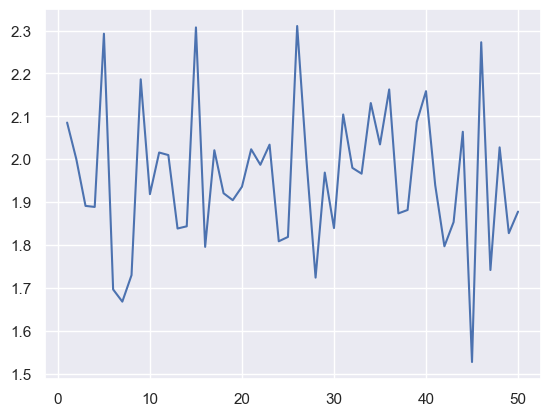

In [29]:
fig, axs = plt.subplots()

sns.lineplot(x=np.arange(1, 51), y=losses, ax=axs)

In [34]:
model = LinearRegression(n_pixels=784, num_classes=n_classes)
optimizer = optim.SGD(model.parameters(), lr=1e-3, weight_decay=1e-2)

checkpoint = torch.load("torch_linear_model.pt")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.eval()

LinearRegression(
  (linear_layer): Linear(in_features=784, out_features=9, bias=True)
)

In [35]:
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, targets in tqdm(train_loader):
        outputs = model(inputs)

        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
        else:
            targets = targets.squeeze().long()
            targets = targets.float().resize_(len(targets), 1)

        y_true.append(targets.detach().numpy().flatten())
        y_pred.append(outputs.detach().numpy().argmax(axis=1))
accuracy_score(np.hstack(y_true), np.hstack(y_pred))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:11<00:00, 62.02it/s]


0.3132805902484555

In [38]:
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, targets in tqdm(test_loader):
        outputs = model(inputs)

        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
        else:
            targets = targets.squeeze().long()
            targets = targets.float().resize_(len(targets), 1)

        y_true.append(targets.detach().numpy().flatten())
        y_pred.append(outputs.detach().numpy().argmax(axis=1))
accuracy_score(np.hstack(y_true), np.hstack(y_pred))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 33.46it/s]


0.4328690807799443

In [32]:
# define a simple CNN model

NUM_EPOCHS = 3
lr = 0.001

class Net(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Net, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes))

    def forward(self, x):
        print(f"I am the input and have the dimensions {x.size()}"
              f" (batch_size, num_channels, x_pixels, y_pixels)")
        x = self.layer1(x)
        """
        print(f"I am the output of the first convolutional layer"
              f" and have the dimensions {x.size()}"
              f"(batch_size, num_channels, x_pixels, y_pixels)")
        x = self.layer2(x)
        print(f"I am the output of the second convolutional layer"
              f" and have the dimensions {x.size()}"
              f"(batch_size, num_channels, x_pixels, y_pixels)")
        x = self.layer3(x)
        print(f"I am the output of the third convolutional layer"
              f" and have the dimensions {x.size()}"
              f"(batch_size, num_channels, x_pixels, y_pixels)")
        x = self.layer4(x)
        print(f"I am the output of the fourth convolutional layer"
              f" and have the dimensions {x.size()}"
              f"(batch_size, num_channels, x_pixels, y_pixels)")
        x = self.layer5(x)
        print(f"I am the output of the fifth convolutional layer"
              f" and have the dimensions {x.size()}"
              f"(batch_size, num_channels, x_pixels, y_pixels)")
        x = x.view(x.size(0), -1)
        print(f"I am the new view of the previous output and"
              f" have the dimensions {x.size()}"
              f"(batch_size, num_channels, x_pixels, y_pixels)")
        print(f"I am furthermore the input of the final linear "
              f"layer.")
        x = self.fc(x)
        print(f"I am the output of the final linear layer"
              f" and have the dimensions {x.size()}"
              f"(batch_size, num_channels, x_pixels, y_pixels)")
        """
        return x

model = Net(in_channels=n_channels, num_classes=n_classes)
    
# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

## Next, we can start to train and evaluate!

In [21]:
# train

for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0
    
    model.train()
    for inputs, targets in tqdm(train_loader):
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model(inputs)
        
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()
        break
    break

  0%|                                                                                                                                                                | 0/704 [00:00<?, ?it/s]

I am the input and have the dimensions torch.Size([128, 3, 28, 28]) (batch_size, num_channels, x_pixels, y_pixels)


  0%|                                                                                                                                                                | 0/704 [00:00<?, ?it/s]


RuntimeError: only batches of spatial targets supported (3D tensors) but got targets of dimension: 1

In [27]:
?nn.BatchNorm2d

In [10]:
# evaluation

def test(split):
    model.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])
    
    data_loader = train_loader_at_eval if split == 'train' else test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()
        
        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)
    
        print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))

        
print('==> Evaluating ...')
test('train')
test('test')

==> Evaluating ...
train  auc: 0.979  acc:0.752
test  auc: 0.947  acc:0.619


# We then check a 3D dataset

In [11]:
data_flag = 'organmnist3d'
download = True

info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

# load the data
train_dataset = DataClass(split='train',  download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 32657407/32657407 [00:08<00:00, 3711033.51it/s]


In [12]:
x, y = train_dataset[0]

print(x.shape, y.shape)

(1, 28, 28, 28) (1,)


In [13]:
for x, y in train_loader:
    print(x.shape, y.shape)
    break

torch.Size([128, 1, 28, 28, 28]) torch.Size([128, 1])


In [14]:
frames = train_dataset.montage(length=1, save_folder="tmp/")
frames[10]

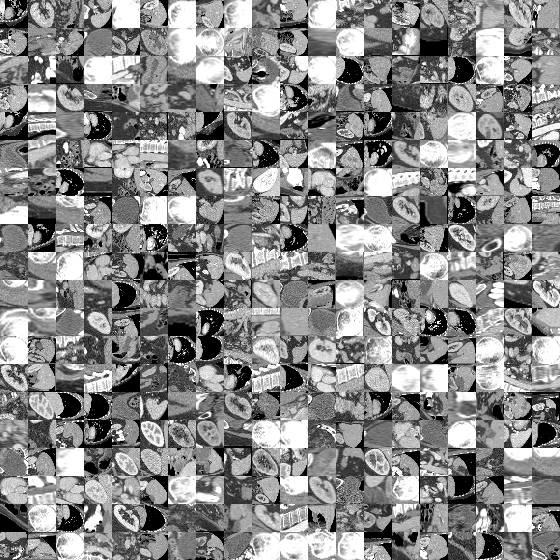

In [15]:
frames = train_dataset.montage(length=20, save_folder="tmp/")

frames[10]